# 1. Setup

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     --------- --------------------------- 41.0/162.8 kB 960.0 kB/s eta 0:00:01
     --------- --------------------------- 41.0/162.8 kB 960.0 kB/s eta 0:00:01
     ----------------------------- ------ 133.1/162.8 kB 782.7 kB/s eta 0:00:01
     ------------------------------------ 162.8/162.8 kB 886.7 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of matpl

## 1.2 Import Dependencies

In [1]:

import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
# setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Making the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# Download the 10,000 image dataset from here
#http://vis-www.cs.umass.edu/lfw/

In [3]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [10]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [11]:
# Import uuid library to generate unique image names
import uuid

In [12]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\265c96aa-0ddb-11ef-8829-e0d4e85a4bcd.jpg'

In [35]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image to screen
    cv2.imshow('Image Collection', frame)
    
    # Break loop if q entered
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

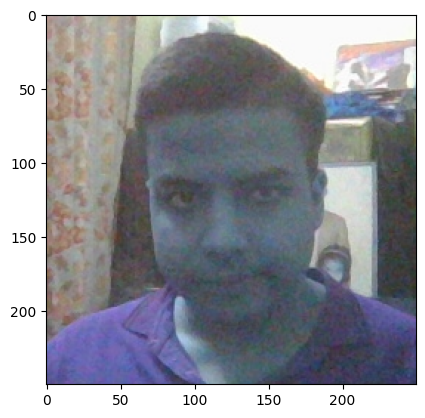

In [36]:
plt.imshow(frame[0:250,0:250, :])

# 2.3 Data Augmentation

In [9]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [24]:
dir_test = anchor.as_numpy_iterator()

In [25]:
print(dir_test.next())

b'data\\anchor\\b33a44a9-0ded-11ef-a2a0-e0d4e85a4bcd.jpg'


## 3.2 Preprocessing - Scale and Resize

In [7]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [27]:
img = preprocess('data\\anchor\\65a1ddcd-0ded-11ef-8818-e0d4e85a4bcd.jpg')

In [28]:
img.numpy().max() 

1.0

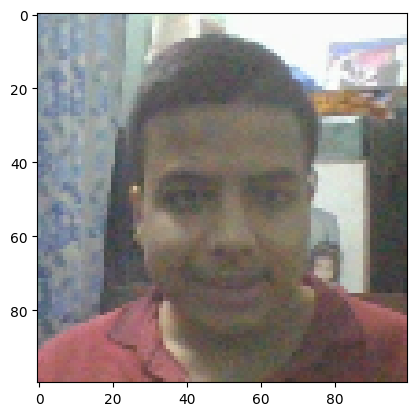

In [29]:
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [30]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [31]:
labels=tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))

In [32]:
iterator=labels.as_numpy_iterator()
print(iterator.next())

1.0


In [8]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [34]:
samples = data.as_numpy_iterator()

In [35]:
example = samples.next()

In [36]:
example

(b'data\\anchor\\ae730e0e-0ded-11ef-ac2c-e0d4e85a4bcd.jpg',
 b'data\\positive\\182e4db7-0dee-11ef-97dc-e0d4e85a4bcd.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [9]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [38]:
res = preprocess_twin(*example) #* to unpack

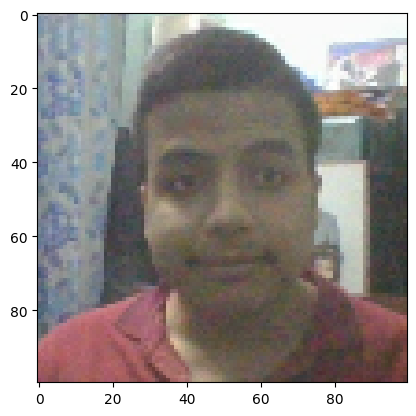

In [39]:
plt.imshow(res[1])

In [40]:
res[2]

1.0

In [10]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [11]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [12]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
# test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [13]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [14]:
embedding = make_embedding()

In [46]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

In [15]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 4.3 Make Siamese Model

In [16]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [17]:
siamese_model = make_siamese_model()

In [50]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [53]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [54]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [55]:

from tensorflow.keras.metrics import Precision, Recall

In [56]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [57]:
EPOCHS = 50

In [58]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 386s 14s/step
0.32896206 0.30097088 1.0

 Epoch 2/50
27/27 [==============================] - 398s 15s/step
0.22970787 0.9514563 1.0

 Epoch 3/50
27/27 [==============================] - 386s 14s/step
0.15493609 0.9238095 0.96517414

 Epoch 4/50
27/27 [==============================] - 373s 14s/step
0.018562859 0.95348835 0.9951456

 Epoch 5/50
27/27 [==============================] - 409s 15s/step
0.04837487 0.97969544 1.0

 Epoch 6/50
27/27 [==============================] - 372s 14s/step
1.4588661e-05 0.9859813 1.0

 Epoch 7/50
27/27 [==============================] - 380s 14s/step
0.42849836 0.9902439 1.0

 Epoch 8/50
27/27 [==============================] - 391s 14s/step
0.042762768 0.9811321 1.0

 Epoch 9/50
27/27 [==============================] - 410s 15s/step
0.0034856047 

KeyboardInterrupt: 

# 6. Evaluate Model

## 6.1 Make Predictions

In [84]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


In [95]:
[1 if prediction > 0.5 else 0 for prediction in yhat ]

[0, 1, 0, 0]

In [94]:
y_true

array([0., 1., 0., 0.], dtype=float32)

In [93]:
yhat

array([[1.3049854e-05],
       [9.8028475e-01],
       [2.7741794e-06],
       [7.1723449e-10]], dtype=float32)

## 6.4 Viz Results

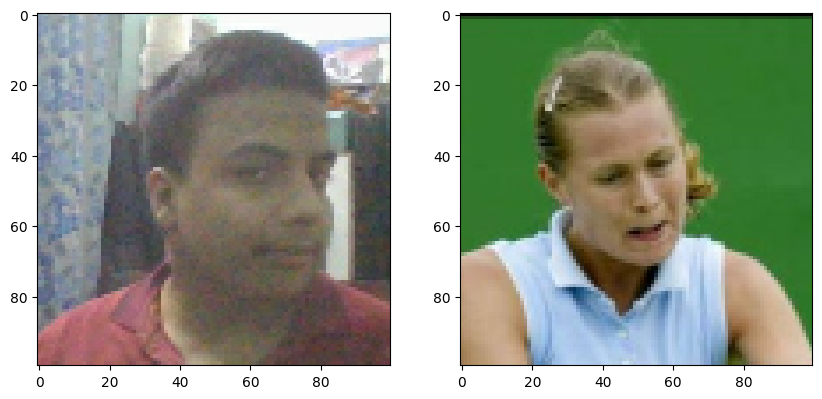

In [98]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Render the plot
plt.show()

# 7. Save Model

In [86]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [36]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [90]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[1.3049854e-05],
       [9.8028475e-01],
       [2.7741794e-06],
       [7.1723449e-10]], dtype=float32)

In [91]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

## 8.1 Verification Function

In [21]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [42]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
False
False
False


In [43]:
np.sum(np.squeeze(results) > 0.5)

21

In [44]:
results

[array([[0.8727643]], dtype=float32),
 array([[0.6671203]], dtype=float32),
 array([[0.6708348]], dtype=float32),
 array([[0.7408598]], dtype=float32),
 array([[0.6867388]], dtype=float32),
 array([[0.50495416]], dtype=float32),
 array([[0.4265414]], dtype=float32),
 array([[0.5738448]], dtype=float32),
 array([[0.00976524]], dtype=float32),
 array([[0.00022206]], dtype=float32),
 array([[0.00022826]], dtype=float32),
 array([[0.00040269]], dtype=float32),
 array([[0.11301491]], dtype=float32),
 array([[0.89158094]], dtype=float32),
 array([[0.85312337]], dtype=float32),
 array([[0.8865283]], dtype=float32),
 array([[0.87861013]], dtype=float32),
 array([[0.5716239]], dtype=float32),
 array([[0.26169357]], dtype=float32),
 array([[0.02733287]], dtype=float32),
 array([[0.3259997]], dtype=float32),
 array([[0.52135396]], dtype=float32),
 array([[0.6609765]], dtype=float32),
 array([[0.66833293]], dtype=float32),
 array([[0.79238904]], dtype=float32),
 array([[0.0012154]], dtype=float32)